In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [78]:
#untie local dependency
import os
cwd = os.getcwd().split('\\')
local_repo_path = '\\'.join(cwd[:-1])
raw_data_path = local_repo_path + r'\data\raw'
processed_data_path = local_repo_path + '\data\processed'
feature_path = local_repo_path + r'\\data\\features'

In [79]:
output_feature_fname = 'keras'
sj_feature_train = pd.read_csv(feature_path + r'\\sj_train_' + output_feature_fname + '.csv', index_col=0)
sj_feature_test = pd.read_csv(feature_path + r'\\sj_test_' + output_feature_fname + '.csv', index_col=0)
iq_feature_train = pd.read_csv(feature_path + r'\\iq_train_' + output_feature_fname + '.csv', index_col=0)
iq_feature_test = pd.read_csv(feature_path + r'\\iq_test_' + output_feature_fname + '.csv', index_col=0)

In [80]:
sj_feature_train.head()

,0,1,2,3,4,total_cases
0,-1.081814,-1.183554,-0.759571,-1.272727,-0.542448,4
1,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,5
2,0.006304,-0.005017,-0.214395,0.000000,-0.530953,4
3,-0.061121,-0.053519,0.110260,0.227273,-0.510605,3
4,0.144991,0.146063,0.741194,0.500000,-0.479789,6


In [81]:
val_len = 50

In [82]:
from sklearn.model_selection import train_test_split
X_tr_sj, X_val_sj  = sj_feature_train.drop('total_cases', axis = 1).iloc[:-val_len,:], sj_feature_train.drop('total_cases', axis = 1).iloc[-val_len:,:]

Y_tr_sj, Y_val_sj = sj_feature_train['total_cases'].iloc[:-val_len], sj_feature_train['total_cases'].iloc[-val_len:]

X_test_sj = sj_feature_test 

X_tr_iq, X_val_iq, = iq_feature_train.drop('total_cases', axis = 1).iloc[:-val_len,:], iq_feature_train.drop('total_cases', axis = 1).iloc[-val_len:,:]

Y_tr_iq, Y_val_iq = iq_feature_train['total_cases'].iloc[:-val_len], iq_feature_train['total_cases'].iloc[-val_len:]

X_test_iq = iq_feature_test

In [83]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [87]:
X_tr_sj = sj_feature_train.drop('total_cases', axis = 1)
Y_tr_sj = sj_feature_train['total_cases']

In [126]:
sj_feature_train.head()

,0,1,2,3,4,total_cases
0,-1.081814,-1.183554,-0.759571,-1.272727,-0.542448,4
1,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,5
2,0.006304,-0.005017,-0.214395,0.000000,-0.530953,4
3,-0.061121,-0.053519,0.110260,0.227273,-0.510605,3
4,0.144991,0.146063,0.741194,0.500000,-0.479789,6


In [127]:
sj_feature_test.head()

,0,1,2,3,4,city,year,weekofyear
0,-0.350555,-0.359024,-0.294028,-0.500000,-0.542448,sj,2008,18
1,-0.399342,-0.410314,-0.490046,-0.272727,-0.541333,sj,2008,19
2,-0.060573,-0.054077,0.306279,0.000000,-0.530953,sj,2008,20
3,-0.405372,-0.407526,0.361409,0.727273,-0.510605,sj,2008,21
4,-0.266685,-0.268153,0.171516,0.227273,-0.479789,sj,2008,22


In [123]:
X_tr_sj_wide = series_to_supervised(X_tr_sj, 10, 1)
#Y_tr_sj = X_tr_sj['var6(t)']
X_tr_sj_wide.head()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),var5(t-9),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
10,-1.081814,-1.183554,-0.759571,-1.272727,-0.542448,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,...,0.475538,0.469965,0.477795,0.727273,-0.167904,0.225024,0.231916,0.147014,-0.500000,-0.077471
11,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,0.006304,-0.005017,-0.214395,0.000000,-0.530953,...,0.225024,0.231916,0.147014,-0.500000,-0.077471,0.347266,0.346202,0.392037,0.500000,0.019901
12,0.006304,-0.005017,-0.214395,0.000000,-0.530953,-0.061121,-0.053519,0.110260,0.227273,-0.510605,...,0.347266,0.346202,0.392037,0.500000,0.019901,0.195423,0.200139,0.385911,0.000000,0.122671
13,-0.061121,-0.053519,0.110260,0.227273,-0.510605,0.144991,0.146063,0.741194,0.500000,-0.479789,...,0.195423,0.200139,0.385911,0.000000,0.122671,0.292449,0.283206,0.441041,0.000000,0.229068
14,0.144991,0.146063,0.741194,0.500000,-0.479789,0.146087,0.157770,0.385911,0.500000,-0.438229,...,0.292449,0.283206,0.441041,0.000000,0.229068,0.428943,0.423693,0.422665,0.227273,0.337125


In [108]:
X_tr_sj_wide.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis = 1, inplace = True)

In [63]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
#X_tr_sj = scaler.fit_transform(X_tr_sj)

In [109]:
# split into train and test sets
values = X_tr_sj_wide.values
n_train = values.shape[0] - 50
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(876, 1, 49) (876,) (50, 1, 49) (50,)


In [110]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 876 samples, validate on 50 samples
Epoch 1/50
 - 1s - loss: 0.2184 - val_loss: 0.1281
Epoch 2/50
 - 0s - loss: 0.1128 - val_loss: 0.0840
Epoch 3/50
 - 0s - loss: 0.0874 - val_loss: 0.0846
Epoch 4/50
 - 0s - loss: 0.0819 - val_loss: 0.0674
Epoch 5/50
 - 0s - loss: 0.0753 - val_loss: 0.0653
Epoch 6/50
 - 0s - loss: 0.0741 - val_loss: 0.0723
Epoch 7/50
 - 0s - loss: 0.0717 - val_loss: 0.0763
Epoch 8/50
 - 0s - loss: 0.0669 - val_loss: 0.0693
Epoch 9/50
 - 0s - loss: 0.0616 - val_loss: 0.0644
Epoch 10/50
 - 0s - loss: 0.0586 - val_loss: 0.0613
Epoch 11/50
 - 0s - loss: 0.0551 - val_loss: 0.0605
Epoch 12/50
 - 0s - loss: 0.0527 - val_loss: 0.0582
Epoch 13/50
 - 0s - loss: 0.0502 - val_loss: 0.0550
Epoch 14/50
 - 0s - loss: 0.0485 - val_loss: 0.0589
Epoch 15/50
 - 0s - loss: 0.0479 - val_loss: 0.0562
Epoch 16/50
 - 0s - loss: 0.0467 - val_loss: 0.0602
Epoch 17/50
 - 0s - loss: 0.0454 - val_loss: 0.0590
Epoch 18/50
 - 0s - loss: 0.0426 - val_loss: 0.0523
Epoch 19/50
 - 0s - loss: 0.

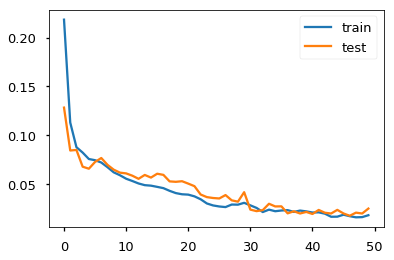

In [111]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [122]:
X_test_sj = series_to_supervised(sj_feature_test.drop(['city','weekofyear', 'year'], axis = 1), 10, 1)
X_test_sj.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis = 1, inplace = True)
X_test_sj = X_test_sj.values.reshape((X_test_sj.shape[0], 1, X_test_sj.shape[1]))
X_test_sj.shape

(250, 1, 50)

In [121]:
model.predict(X_test_sj)

ValueError: Error when checking input: expected lstm_3_input to have shape (1, 49) but got array with shape (1, 50)